In recent years there has been an explosion of ML models in computational biology. One area that has had enormous amounts of compute-hours sunk into it, is the development of genomic sequence models. These models are trained on genomic sequences ie. {AGCTGAAGGT...} to predict genomic quantities. 

These quantities are things like gene expression, chromatin accessibility, RNA degradation. The genomic hypothesis is that the majority of human variation, particularly in regards to disease, stems from difference in genetic sequence (ie. due to random mutations, inherited or acquired). So if we can perfectly predict how sequence affects gene expression, we have a powerful tool for disease understanding and drug development.

There has been considerable success in the development of these models. They boast state-of-the-art prediction accuracy in almost every task. But the ultimate usecase isn't prediction - it's generation. Yes, predicting how a mutated sequence may lead to a lower gene expression value is nice, but what we really want is to propose some perturbations to the sequence so that we can increase gene expression.

So let's frame this as a mathematical question. Our sequence model is just a function $f(x)$ that takes in a sequence of length n, and outputs a gene expression value. We are interested in optimizing this function.

 $$\max_{b_1, b_2, ..., b_n} f(b_1, b_2, ..., b_n)$$

where

$$b_i \in (A,C,G,T)$$

but in practice we represent the oracle function as actually operating over one-hot vectors

$$f(\vec{b_1}, \vec{b_2}, ...,\vec{b_n})$$

$$b_i \in \begin{bmatrix}1 \\0 \\0\\0\end{bmatrix}, \begin{bmatrix}0 \\1 \\0\\0\end{bmatrix}, \begin{bmatrix}0 \\0 \\1\\0\end{bmatrix}, \begin{bmatrix}0 \\0 \\0\\1\end{bmatrix}$$

Now optimizing this function is hard - the input space is hugely dimensional (4 bases x $\sim${1000} positions). One advantage of $f$ being a neural network is that we have an additional important piece of information - the gradient, thanks to autodifferentiation.

##Gradient Ascent

Now the obvious thing here to is gradient ascent. The formulation of the problem is

Given a function that operates on a sequence of vectors $$f(b_1, b_2, ..., b_n)$$, for each vector component, follow its gradient. 

$$b_i^{(t+1)} =b_i^{(t)}+\alpha\frac{\partial{f}}{\partial{b_i^{(t)}}}$$

We implement this.

We'll use BPNet as our oracle model. ![BPNet](https://www.nature.com/articles/s41588-021-00782-6) (Avsec et al., 2021) is a convolution neural network that is trained to predict transcription-factor binding. 

Transcription factors are proteins that regulate gene expression by binding to specific DNA sequences. They act as molecular switches, turning genes on or off. We're interested in optimizing a sequence to maximize gene transcription, because by increasing transcription, we can increase expression and therefore protein count. Many diseases are caused by too much or too little of essential proteins. 

Our optimization process will start off from an arbitrary gene sequence in the human genome. We want to give our model a good "starting point", and a gene sequence found in the human genome will be more likely to be "in distribution" of the data the model was trained on.  

In [2]:
%matplotlib inline 
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyfaidx
from tangermeme.utils import one_hot_encode
import genomic_optimization.visualizations as visualizations
import genomic_optimization.optimizations as optimizations
from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper
#Define a sample region of the genome to optimize.
chrom, mid = "chr1", 246_507_312
model = torch.load("GATA2.torch", weights_only=False)


model = CountWrapper(ControlWrapper(model))

FileNotFoundError: [Errno 2] No such file or directory: 'GATA2.torch'

The model outputs log-counts of estimated transcription factor binding. Higher predicted log counts means higher predicted binding activity. 

(The reason the model predicts log counts is because the data it was trained on are log-read counts of protein binding.)

In [2]:
def reset_sequence():
    chrom, mid = "chr1", 246_507_312 #was 507
    X = pyfaidx.Fasta("hg38.fa")[chrom][mid-1057:mid+1057].seq.upper()
    X = one_hot_encode(X).unsqueeze(0).float().cuda()
    X.requires_grad = True
    y = model(X)
    y.backward()
    return X

In [3]:
def reset_sequence_logits():
    chrom, mid = "chr1", 246_507_312 #was 507
    X = pyfaidx.Fasta("hg38.fa")[chrom][mid-1057:mid+1057].seq.upper()
    X = one_hot_encode(X).unsqueeze(0).float().cuda()
    X[X==1] = 5
    X.requires_grad = True
    y = model(torch.nn.functional.softmax(X))
    y.backward()
    return X

First we will run gradient ascent on the one hot sequence as input, optimizing the model output as our y-value.

The function `run_gradient_optimization` will take in initial one hot matrix `X` and optimize it continuously (no longer discrete). During the optimization process it will no longer be a genomic sequence (because it is not one hot), but at each step we will take the argmax of the relaxed sequence as the genomic sequence that is represented by it. 

`optimizations.run_gradient_optimization` will return:

`optimization_results` which is an np.array of model predicted binding values of the relaxed sequence

`one_hot_results` which is an np.array of model predicted binding values of the one hot sequence (derived from argmax of relaxed sequence)

`optimization_edits` which is an np.array of the one hot sequence changes at each iteration

`trajectory` which is an np.array of the four base components of `base_to_log=1005` (which has been cherry-picked for a good visualization for this notebook)

One-hot elements: 
 tensor([[0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SliceBackward0>)


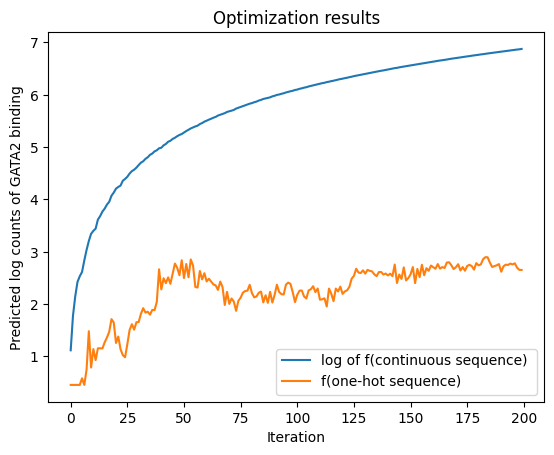

In [41]:
X = reset_sequence()
print("One-hot elements: \n",X[0,:,:10])
optimization_results, one_hot_results, optimization_edits, trajectory = optimizations.run_gradient_optimization(X, model, update_function=optimizations.gradient_ascent, n_iterations=200)
plt.plot(np.log(optimization_results), label="log of f(continuous sequence) ")
plt.plot(one_hot_results, label="f(one-hot sequence)")
plt.title("Optimization results")
plt.xlabel("Iteration")
plt.ylabel("Predicted log counts of GATA2 binding") 
plt.legend()

Looks like the optimization is working, our one hot sequences go from `0.45` predicted log counts to `2`, a 4.7x increase. But the problem is that our continuous relaxed sequences have predicted log(log counts) from `1->6`, a 148x increase. 

This discrepancy between the continuous sequence and the one hot sequence is quite concerning. 

Let's use the visualization tools from `visualizations` to help us.

We can use `visualizations.edit_heatmap` to take a look at the one-hot edits made by our optimization

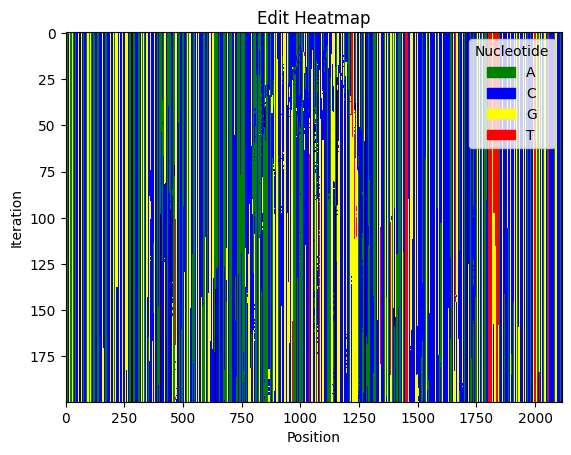

In [42]:
visualizations.edit_heatmap(optimization_edits)

Nothing too crazy is happening. The one hot edits mostly don't deviate too much from the original sequence. 

But what about the continuous sequences from which the one hot is derived?

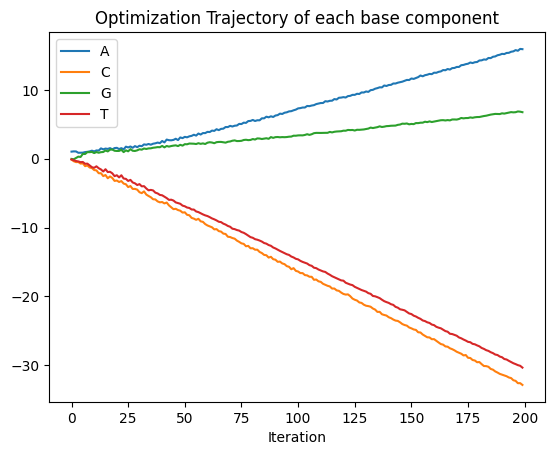

In [43]:
visualizations.visualize_base_trajectories(trajectory)

We see that although the one-hot sequence remains the same, each component is diverging over the course of the optimization. 

What this means is that over the course of optimization, following the gradient is going to lead us further away from the unit vectors `[1 0 0 0], [0 1 0 0], [0 0 1 0], [0 0 0 1]` which represent our nucleotides!

(0.0, 5.0)

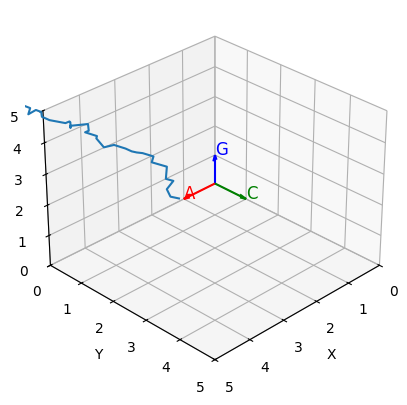

In [44]:
ax = visualizations.plot_unit_vectors()
# Plot the trajectory in 3D
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label="Optimization Trajectory")
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])


This has a big possibility of landing into an area of R4 that is out of distribution for the model. OOD means that the optimization vectors we are giving the model are lie far away from the data it was trained on. Querying the model with OOD data leads to uninformative results.

Our ML model of protein binding was trained on purely one hot data, and so our assumption is that any input that is not "near" one hot could be OOD. We can't tell for sure, but we can try to investigate what types of input are OOD for the model.

##Part 2: Model OOD detection

For this section we will be trying to investigate what types of input are OOD for our model. The way we will do this is by:

1. Randomly sample one-hot sequence data and observe the empirical distribution of model outputs
2. Randomly sample non ont-hot sequence data (using a variety of sampling schemes) and observe this empirical distribution.
3. Compare these distributions. 

In [9]:
#1. perturb actual bases, see distribution. 
def perturb_bases(X, perturb_start, perturb_end):
    X_copy = X.clone()
    for i in range(perturb_start, perturb_end):
        X_copy[0,:,i] = torch.from_numpy(np.eye(4)[np.random.randint(0,4)]).float()
    return X_copy 

def perturb_normal(X, perturb_start, perturb_end):
    X_copy = X.clone()
    for i in range(perturb_start, perturb_end):
        X_copy[0,:,i] = torch.from_numpy(np.random.normal(0, 0.5, size=(4))).float()
    return X_copy

def perturb_simplex(X, perturb_start, perturb_end):
    X_copy = X.clone()
    for i in range(perturb_start, perturb_end):
        X_copy[0,:,i] = torch.from_numpy(np.random.dirichlet(np.ones(4), size=1)).float()
    return X_copy

def perturb_uniform(X, perturb_start, perturb_end):
    X_copy = X.clone()
    for i in range(perturb_start, perturb_end):
        X_copy[0,:,i] = torch.from_numpy(np.random.uniform(0, 1, size=(4))).float()
    return X_copy

def perturb_outline(X, perturb_start, perturb_end):
    X_copy = X.clone()

    base_dict = {
        'A': np.array([1, 0, 0, 0]),
        'C': np.array([0, 1, 0, 0]),
        'G': np.array([0, 0, 1, 0]),
        'T': np.array([0, 0, 0, 1])
    }

    for i in range(perturb_start, perturb_end):
        #First pick which line we are on. A-G line? or C-G line?
        [start, end] = np.random.choice(["A", "C", "G", "T"], 2, replace=False)
        #Then pick distance along the line
        distance = np.random.uniform(0, 1)
        #Then interpolate between the two points
        start_point = base_dict[start]
        end_point = base_dict[end]
        delta = end_point - start_point
        point = start_point + distance*delta
        X_copy[0,:,i] = torch.from_numpy(point).float()
    return X_copy

In [11]:
start_pos = 800
end_pos = 820
n_samples = 500

X = pyfaidx.Fasta("hg38.fa")[chrom][mid-1057:mid+1057].seq.upper()
X = one_hot_encode(X).unsqueeze(0).float().cuda()
y = model(X)
y_true = y.cpu().detach().numpy()

Sampling one-hot sequence data:

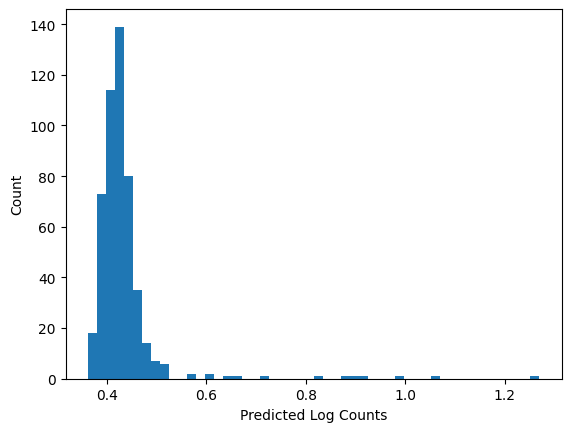

In [14]:
perturb_bases_dist = []
for i in range(n_samples):
    X_copy = perturb_bases(X, start_pos, end_pos)
    y = model(X_copy)
    perturb_bases_dist.append(y.item())
plt.hist(perturb_bases_dist, bins=50)
plt.ylabel("Count")
plt.xlabel("Predicted Log Counts")
plt.show()

Sampling one hot sequence data can be thought of as sampling unit vectors for each sequence position:

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

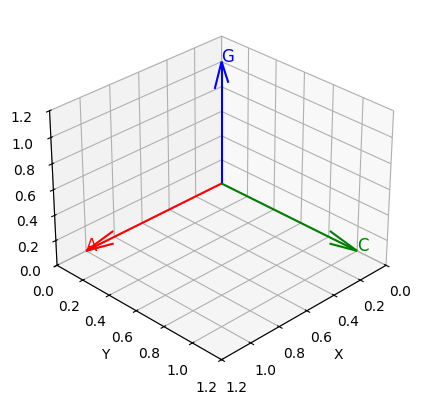

In [17]:
visualizations.plot_unit_vectors()

Sampling normally distributed sequence components - now for each sequence position, instead of sampling a unit vector, we will sample a multivariate normal vector. 

Plotted is a shell of the 3D normal distribution we are using, `mean=[0.5, 0.5, 0.5, 0.5], cov=[0.5]*I`. 

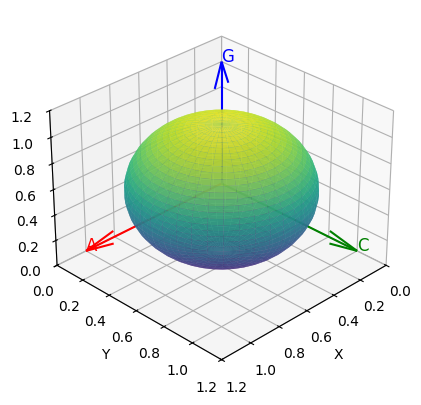

In [18]:
from scipy.stats import multivariate_normal 

ax = visualizations.plot_unit_vectors()
mean_shell = np.array([0.5, 0.5, 0.5])  # Center of the sphere
radius = 0.5  # Radius of the shell

# Create a sphere using spherical coordinates
theta = np.linspace(0, np.pi, 40)  # Polar angle
phi = np.linspace(0, 2 * np.pi, 40)  # Azimuthal angle
Theta, Phi = np.meshgrid(theta, phi)

# Convert spherical coordinates to Cartesian
X_shell = mean_shell[0] + radius * np.sin(Theta) * np.cos(Phi)
Y_shell = mean_shell[1] + radius * np.sin(Theta) * np.sin(Phi)
Z_shell = mean_shell[2] + radius * np.cos(Theta)
ax.plot_surface(X_shell, Y_shell, Z_shell, cmap="viridis", alpha=0.8)
plt.show()

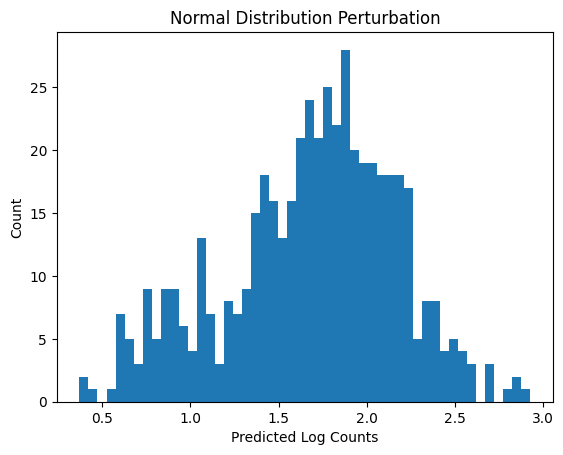

In [15]:
perturb_normal_dist = []
for i in range(n_samples):
    X_copy = perturb_normal(X, start_pos, end_pos)
    y = model(X_copy)
    perturb_normal_dist.append(y.item())
plt.hist(perturb_normal_dist, bins=50)
plt.ylabel("Count")
plt.xlabel("Predicted Log Counts")
plt.title("Normal Distribution Perturbation")
plt.show()

Sampling uniformly on the simplex - another set of data we're interested in is the simplex - this is the set of all points in which the sum of all components adds up to 1. This emerges as a more natural candidate for a continuous approximation of one-hot vectors.

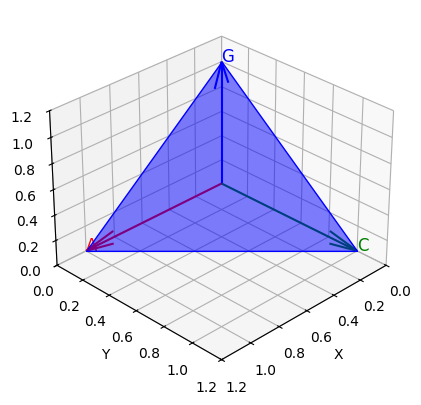

In [21]:
ax = visualizations.plot_unit_vectors()

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define the simplex vertices (standard 2-simplex in 3D)
simplex_vertices = np.array([
    [1, 0, 0],  # Vertex A
    [0, 1, 0],  # Vertex C
    [0, 0, 1]   # Vertex G
])

# Define the triangular face of the simplex
simplex_faces = [[simplex_vertices[0], simplex_vertices[1], simplex_vertices[2]]]
ax.add_collection3d(Poly3DCollection(simplex_faces, color='blue', alpha=0.5))


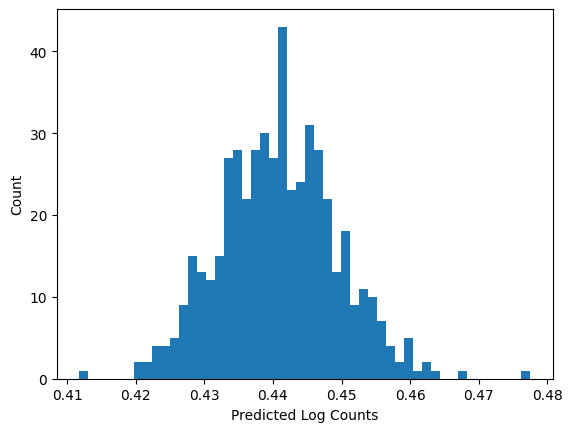

In [23]:
perturb_simplex_dist = []
for i in range(n_samples):
    X_copy = perturb_simplex(X, start_pos, end_pos)
    y = model(X_copy)
    perturb_simplex_dist.append(y.item())
plt.hist(perturb_simplex_dist, bins=50)
plt.ylabel("Count")
plt.xlabel("Predicted Log Counts")
plt.show()

Sampling uniformly - finally we look at the effect of sampling uniformly along `[0,1]` for each sequence component. Though this doesn't have same analogy to one-hot vectors as simplex sampling, it does bound each sequence component to be between `[0,1]`. 

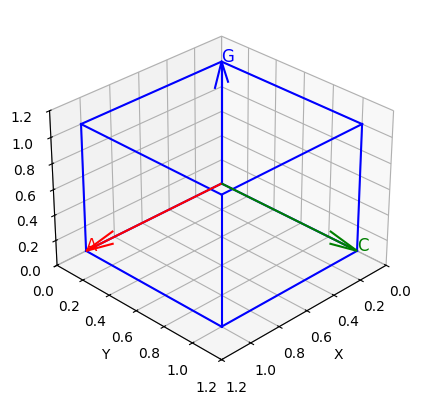

In [25]:
ax = visualizations.plot_unit_vectors()

# Define the cube parameters
cube_center = np.array([0.5, 0.5, 0.5])  # Center of the cube
cube_size = 1.0  # Length of cube edges

# Generate cube vertices
half_size = cube_size / 2
x = [-half_size, half_size]
y = [-half_size, half_size]
z = [-half_size, half_size]

# Define cube edges
cube_vertices = np.array([[i, j, k] for i in x for j in y for k in z])
cube_vertices += cube_center  # Shift cube to the desired center

# Define cube edges (pairs of vertices)
edges = [
    (0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3),
    (2, 6), (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)
]

# Plot the cube edges
for edge in edges:
    points = cube_vertices[list(edge)]
    ax.plot3D(*points.T, color='b')


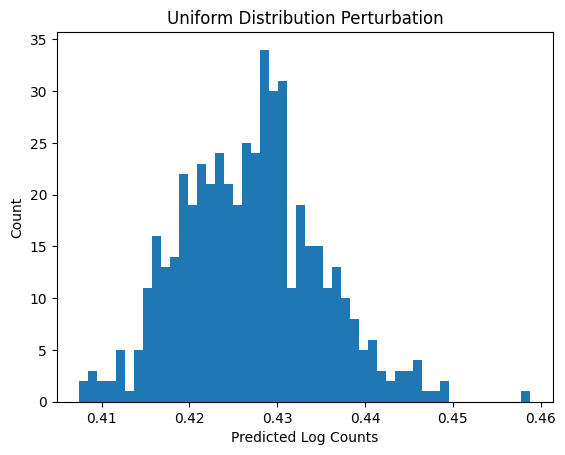

In [27]:
perturb_uniform_dist = []
for i in range(n_samples):
    X_copy = perturb_uniform(X, start_pos, end_pos)
    y = model(X_copy)
    perturb_uniform_dist.append(y.item())
plt.hist(perturb_uniform_dist, bins=50)
plt.ylabel("Count")
plt.xlabel("Predicted Log Counts")
plt.title("Uniform Distribution Perturbation")
plt.show()

Plotting the histogram of all samples, we can see that most sampling schemes we built result in an empirical distribution very similar to the one-hot sequences (perturb_bases). But sampling normally results in very different model output. 

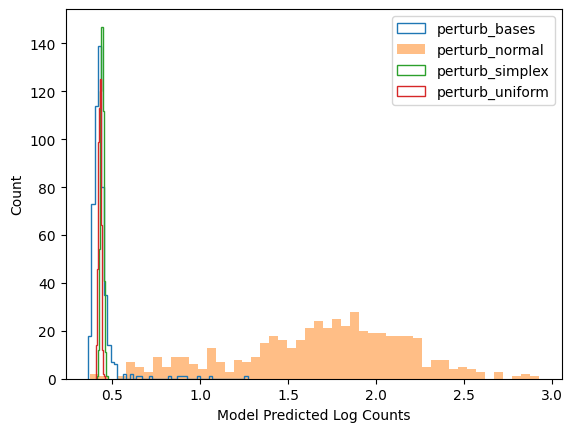

In [29]:
plt.hist(perturb_bases_dist, histtype="step", bins=50, label="perturb_bases")
plt.hist(perturb_normal_dist, bins=50, alpha=0.5, label="perturb_normal")
plt.hist(perturb_simplex_dist, histtype="step", bins=10, label="perturb_simplex")
plt.hist(perturb_uniform_dist, histtype="step", bins=10, label="perturb_uniform")
#plt.xlim(0,0.8)
plt.xlabel("Model Predicted Log Counts")
plt.ylabel("Count")
plt.legend()

So what does this tell us? 

It tells us that during our optimization, we need to stay close to the origin - to get model output that remains similar in distribution to output from one-hot sequences.  

##Part 3: Directional gradient ascent

Inspired by these results, I set to modify the gradient ascent procedure, with the objective of "keeping our input close to the origin". 

I had initially tried techniques like clipping the output, scaling the gradient, but these all seemed artificial in the way they treated the constraints.  

The final idea I settled on is directional gradient ascent - instead of blindly following the gradient direction, let's only consider the gradient of the model, **in the direction of our one-hot bases**. 

The update rule for gradient ascent:

$$b^{(t+1)} =b^{(t)}+\alpha\nabla{f(\vec{x})}$$

Becomes the following:

$$b^{(t+1)} =b^{(t)}+\arg\max_{x\in{S}}||x||_2^2$$

$$S =  \left\{
\begin{array}{l}
\nabla_{x\rightarrow{A}}f(\vec{x}) \\
\nabla_{x\rightarrow{C}}f(\vec{x}) \\
\nabla_{x\rightarrow{G}}f(\vec{x}) \\
\nabla_{x\rightarrow{T}}f(\vec{x}) \\
\end{array}
\right\}$$

The notation $$\nabla_{x\rightarrow{A}}$$ is a **directional gradient** and it represents the gradient of the function, in the direction of the unit vectors (which represent the bases)

$$\nabla_{x\rightarrow{A}} = (\nabla{f(\vec{x})}\cdot{\vec{D_{x\rightarrow{A}}}})\vec{D_{x\rightarrow{A}}}$$

where $$\vec{D_{x\rightarrow{A}}} = \frac{\vec{A} - \vec{x}}{||\vec{A} - \vec{x}||_2}$$


![gradients](diagram-20250405.png)

Why use directional gradients? 

I don't have a theoretical proof of why this works. But the idea is, we are still doing gradient ascent, except we are *only interested in the gradient directions that bring us closer to the unit vectors*. But we can only optimize towards one base at a time (in an attempt to respect the one-hot nature of genomic sequences.)

This also helps us stay close to the unit vectors - the directional gradients (the directions that we optimize towards) **always** point towards the unit vectors. 

We can visualize the effect of directional gradients with 
`optimizations.directional_ascent` function. 


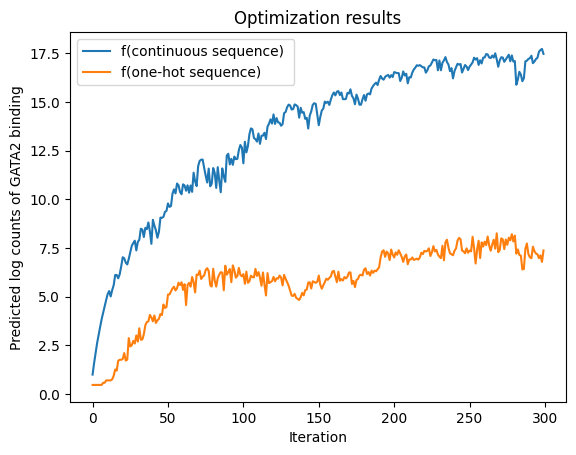

In [51]:
X = reset_sequence()
optimization_results, one_hot_results, optimization_edits, trajectory = optimizations.run_gradient_optimization(X, model, update_function=optimizations.directional_ascent, n_iterations=300)
plt.plot(optimization_results, label="f(continuous sequence) ")
plt.plot(one_hot_results, label="f(one-hot sequence)")
plt.title("Optimization results")
plt.xlabel("Iteration")
plt.ylabel("Predicted log counts of GATA2 binding") 
plt.legend()

Much better optimization trajectories with directional gradients. We can get a 260x increase in protein binding, and the continuous optimization results do not explode away from the one hot sequences. (notice the plot is not log transformed this time. )

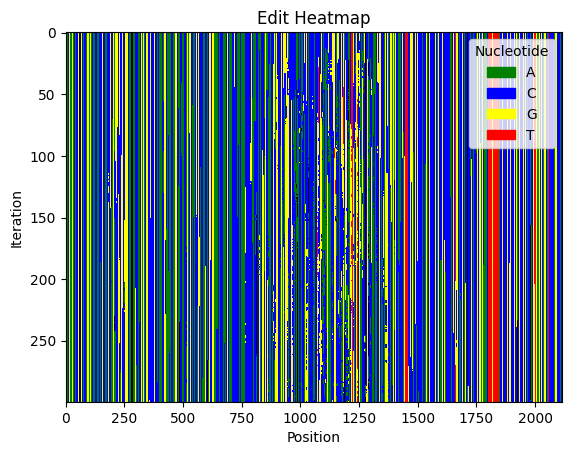

In [52]:
visualizations.edit_heatmap(optimization_edits)

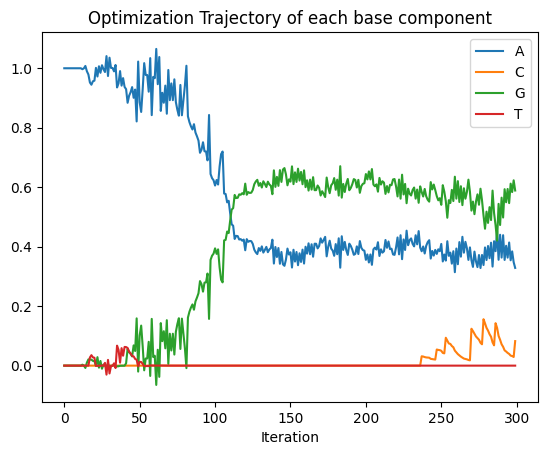

In [53]:
visualizations.visualize_base_trajectories(trajectory)

We also have much more interpretable results when looking at the unit vector components of each position, as the optimization process goes on (of course, this example is sort of cherry picked). Instead of exploding, components stay relatively bounded between `[0,1]`, and we have much more interpretable behaviour.

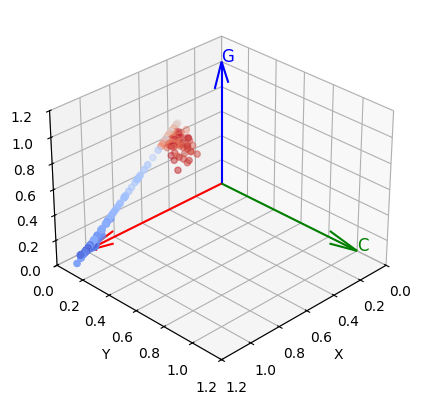

In [57]:
ax = visualizations.plot_unit_vectors()
# Plot the trajectory in 3D
indices = np.linspace(0, 1, trajectory.shape[0])
cmap = plt.get_cmap('coolwarm')
colors = cmap(indices)

# Plot
ax.scatter(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], c=colors, label="Optimization Trajectory")


Visualizing the optimization trajectory of a single base with lets us see that the trajectories are much more well behaved and offer interpretable results - in this case, seqeuence position 1005 converges to a position in between A and G, indicating that either one base is fine. 